The file sunspot.txt provides monthly data on the number of sunspots from 1749 to 2013. Columns of this file are Tab separated. The actual data form the third column of the file. I’m not sure why these data are non-integer, probably they are some averages. Try denoising this series using
1. the Wiener filter
2. wavelet denoising with your favourite wawelet package.

In either case, you will need to truncate the series so its length is $2^k$. Apart from that, try fitting a seasonal model to the original data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.linear_model import LinearRegression
from lib import *

import pywt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('seaborn-colorblind')

import statsmodels.api as sm
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

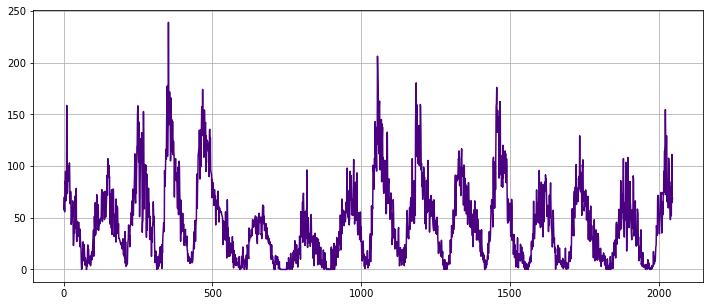

In [2]:
signal = np.loadtxt('data/sunspot.txt').T[2]     ## data form 1749 to 2013
signal = signal[:2048]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(signal, c='indigo')
ax.grid(True)
plt.show()

In [3]:
N = len(signal)             ## number of points
Δt = 1      ## timestep = how often signal is sampled
f_Nyq = 1/(2*Δt)          ## Nyquist frequency
f_Nyq

0.5

In [4]:
def get_power_spectrum(signal, N):
    
    signal_fft = fft(signal, norm = 'ortho')        ###  DFT  
    frequency = fftfreq(N, Δt)[:N//2]               ###  only non-negative frequenties

    power_spectrum = np.zeros(N//2)
    power_spectrum[0] = np.abs(signal_fft[0])**2
    power_spectrum[-1] = np.abs(signal_fft[N//2])**2
    for n in range(1, N//2):
        power_spectrum[n]= np.abs(signal_fft[n])**2 + np.abs(signal_fft[-n])**2
    
    return frequency, power_spectrum

In [5]:
frequency, power_spectrum = get_power_spectrum(signal, N)

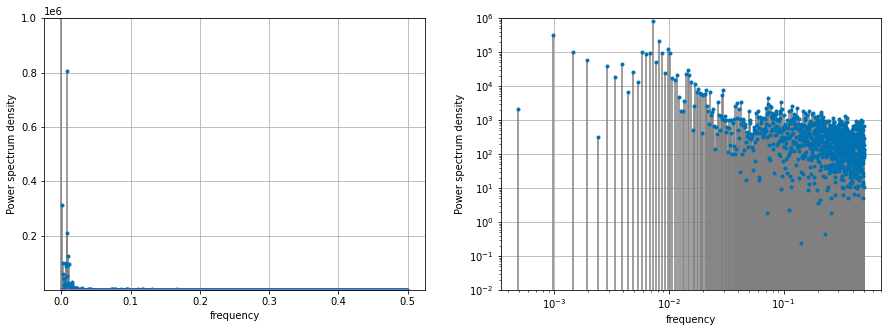

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].stem(frequency, power_spectrum, linefmt='grey', markerfmt='.')
axs[1].stem(frequency, power_spectrum, linefmt='grey', markerfmt='.')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

for ax in axs:
    ax.set_xlabel('frequency')
    ax.set_ylabel('Power spectrum density')
    ax.grid(True)
    ax.set_ylim(1e-2, 1e6)

plt.show()

# Wiener filter with const cutoff

In [7]:
def noise_spectrum(f, N0):
    return N0 + f*0.0

In [8]:
def Wiener_filter(frequency, power_spectrum, N0):
    
    noise = noise_spectrum(frequency, N0)
    Φ = ( power_spectrum - np.abs(noise)**2) / power_spectrum 
    Φ = np.where(Φ< 0, 0, Φ)
    
    return Φ

In [9]:
def visual_comparison(frequency, power_spectrum, N, N0):
    
    noise = noise_spectrum(frequency, N0)**2
    filetr = Wiener_filter(frequency, power_spectrum, N0)
    
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    axs[0].plot(frequency, power_spectrum, c='darkblue', label = 'signal')
    axs[0].plot(frequency, noise, c='red', label = 'noise')
    axs[1].plot(frequency, filetr, c='red')

    axs[0].set_ylabel('Power spectrum density')
    axs[1].set_ylabel('Wiener filter')

    for ax in axs:
        ax.set_xlabel('frequency')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(1e-2, 1e6)
        ax.grid(True)
    plt.show()


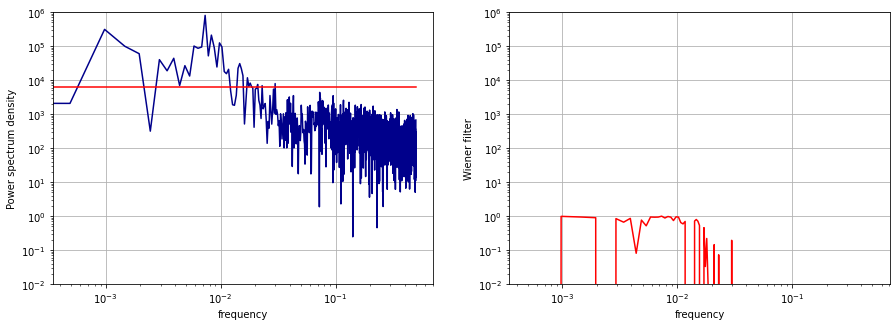

In [10]:
N0 = 80
visual_comparison(frequency, power_spectrum, N, N0)

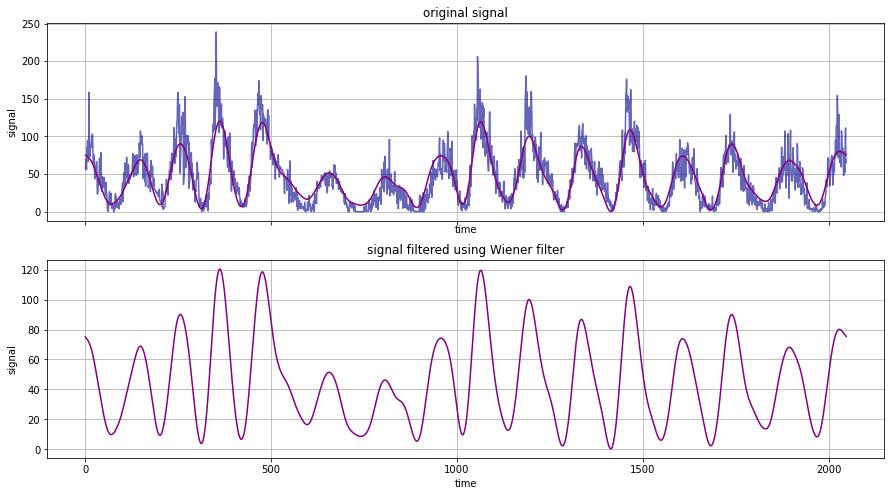

In [11]:
filtr = Wiener_filter(frequency, power_spectrum, N0)
filtr_extended = np.hstack((filtr, np.flip(filtr)))

signal_fft = fft(signal, norm = 'ortho')    
signal_fft_filtred = signal_fft * filtr_extended
signal_filtred = np.real(ifft(signal_fft_filtred, norm = 'ortho') )

fig, axs = plt.subplots(2, 1, figsize=(15,8), sharex = True)
axs[0].plot(signal, c='darkblue', alpha=0.6)
axs[0].plot(signal_filtred, c='purple')
axs[1].plot(signal_filtred, c='purple')

axs[0].set_title("original signal")
axs[1].set_title("signal filtered using Wiener filter")

for ax in axs:
    ax.set_xlabel('time')
    ax.set_ylabel('signal')
    ax.grid(True)
plt.show()

In [12]:
frequency_filtred, power_spectrum_filtred = get_power_spectrum(signal_filtred, N)

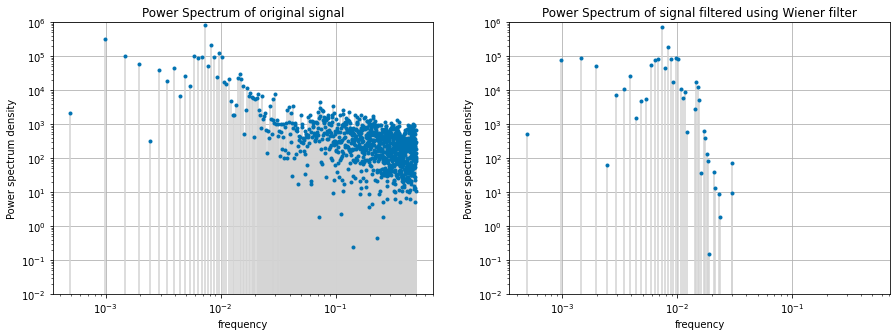

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].stem(frequency_filtred, power_spectrum, linefmt='lightgrey', markerfmt='.')
axs[1].stem(frequency_filtred, power_spectrum_filtred, linefmt='lightgrey', markerfmt='.')

axs[0].set_title("Power Spectrum of original signal")
axs[1].set_title("Power Spectrum of signal filtered using Wiener filter")


for ax in axs:
    ax.set_xlabel('frequency')
    ax.set_ylabel('Power spectrum density') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1e6)
    ax.grid(True)
plt.show()

# Wavelet denoising with different wawelet packages

In [14]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [15]:
def wavelet_denoising(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

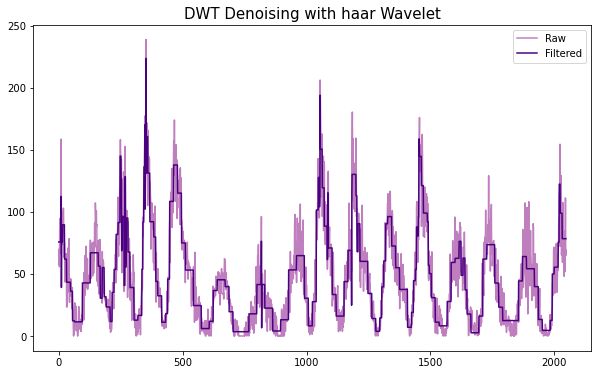

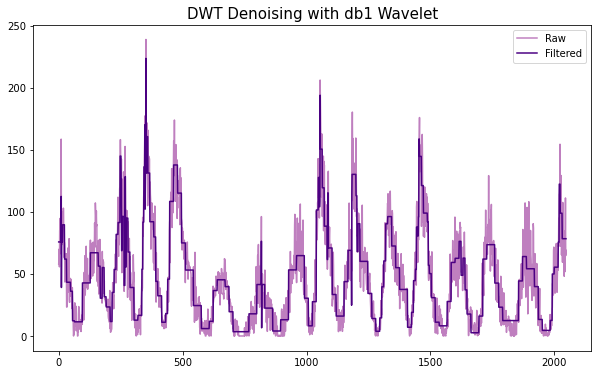

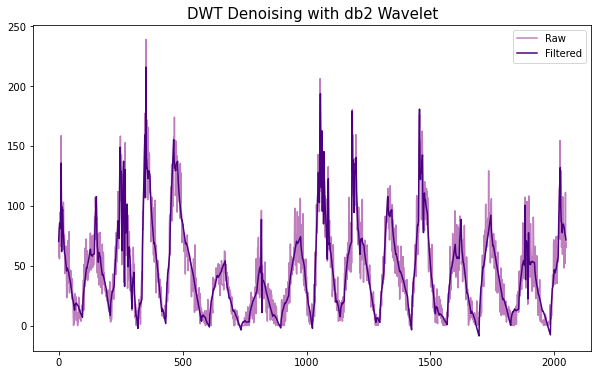

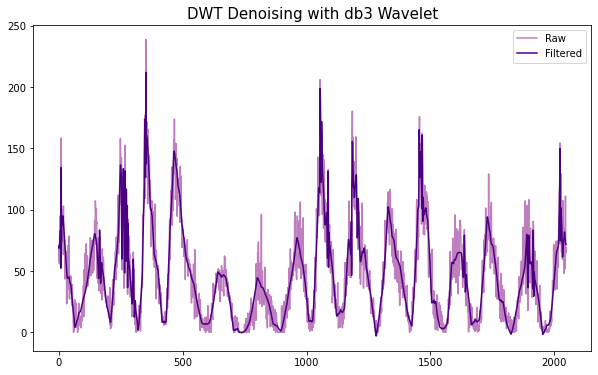

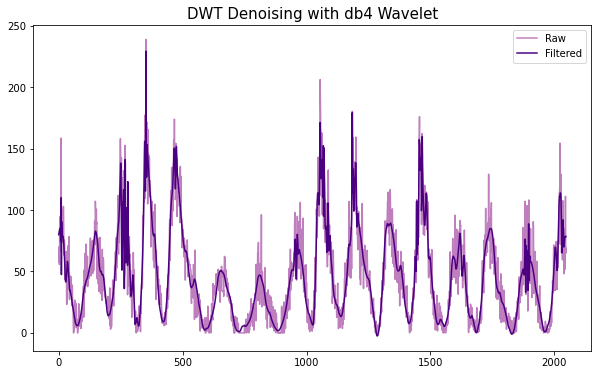

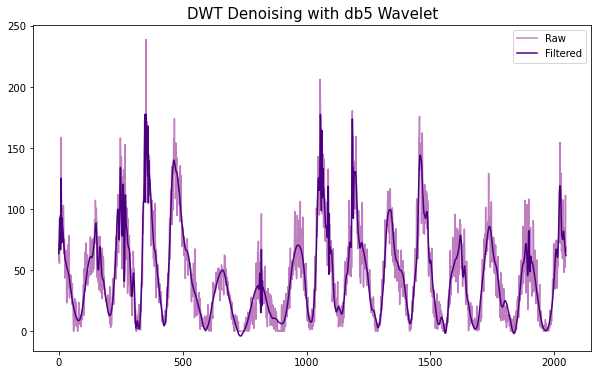

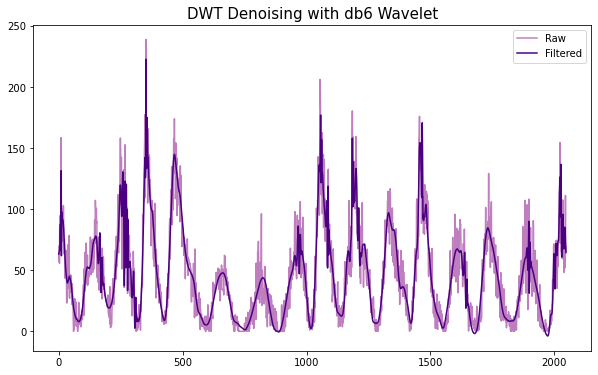

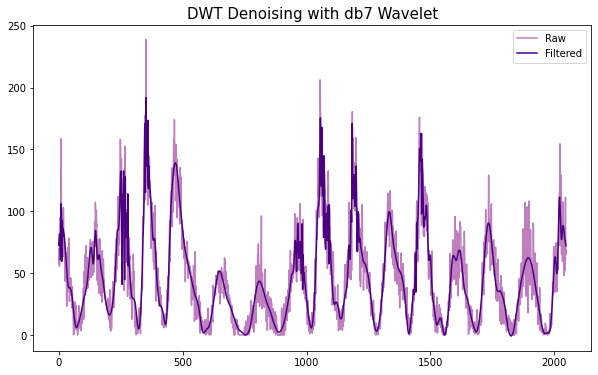

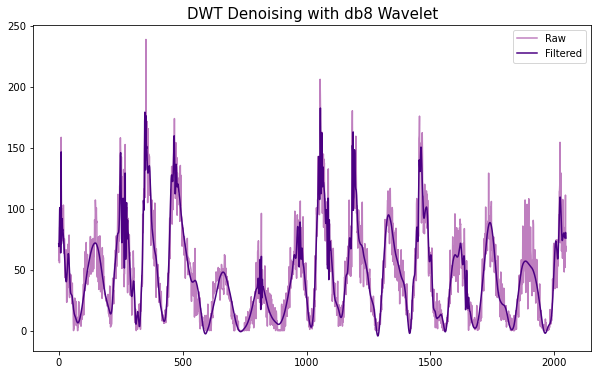

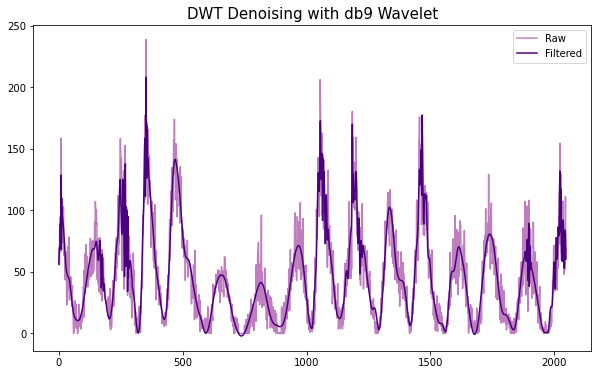

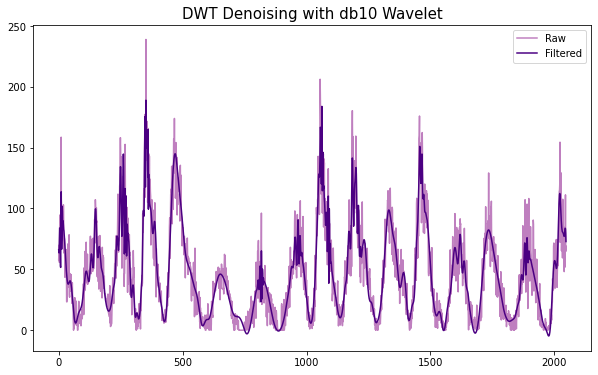

In [16]:
wavelist = ['haar', 'db1',  'db2',  'db3',  'db4',  'db5',  'db6', 'db7', 'db8', 'db9', 'db10']
for wav in wavelist:
    try:
        filtered = wavelet_denoising(signal, wavelet=wav, level=1)
    except:
        pass
    
    plt.figure(figsize=(10, 6))
    plt.plot(signal, label='Raw', color ='purple' ,alpha=0.5)
    plt.plot(filtered, label='Filtered', color = 'indigo')
    plt.legend()
    plt.title(f"DWT Denoising with {wav} Wavelet", size=15)
    plt.show()

###  Autocorrelation function (ACF) 

In [17]:
signal_filtred = wavelet_denoising(signal, wavelet='db9', level=1)

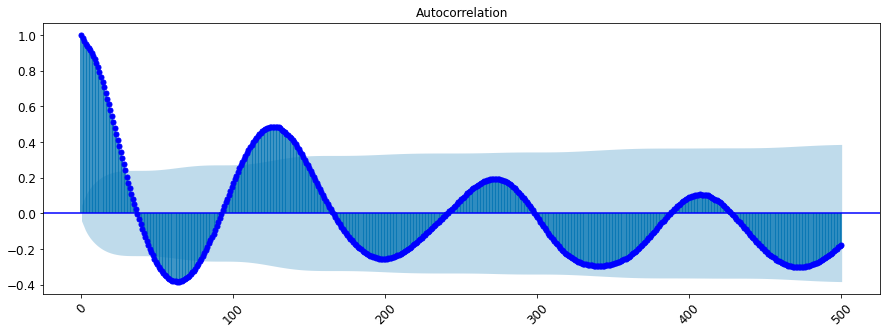

In [18]:
plt.rcParams["figure.figsize"] = (15,5)

p =500

plot_acf(signal_filtred, lags = p,color ='blue')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

###  Partial autocorrelation function (PACF) 

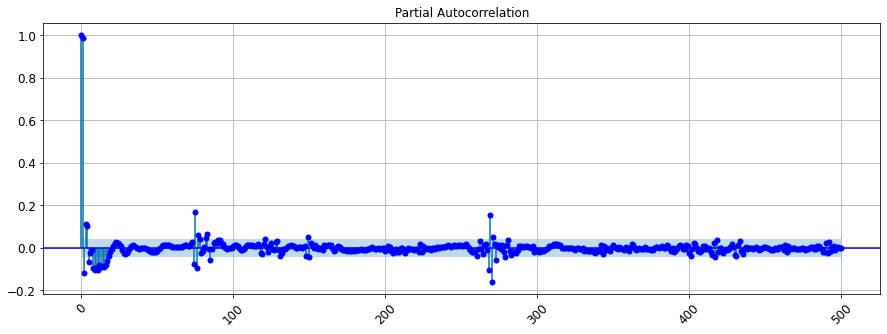

In [19]:
plot_pacf(signal_filtred, lags = p, method = 'ywmle',color ='blue')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

# searching for seasonality

In [20]:
df = pd.DataFrame(signal_filtred, columns = ['y_t'])

df['y_(t126)'] = df['y_t'].shift(-126)
df['y_(t127)'] = df['y_t'].shift(-127)
df['y_(t128)'] = df['y_t'].shift(-128)

df['y_(t62)'] = df['y_t'].shift(-62)
df['y_(t63)'] = df['y_t'].shift(-63)
df['y_(t64)'] = df['y_t'].shift(-64)

df['y_(t121)'] = df['y_t'].shift(-121)
df['y_(t122)'] = df['y_t'].shift(-122)
df['y_(t123)'] = df['y_t'].shift(-123)


df['y_(t4)'] = df['y_t'].shift(-4)
df['y_(t5)'] = df['y_t'].shift(-5)
df['y_(t6)'] = df['y_t'].shift(-6)
df['y_(t7)'] = df['y_t'].shift(-7)
df['y_(t8)'] = df['y_t'].shift(-8)
df['y_(t9)'] = df['y_t'].shift(-9)

df['y_(t10)'] = df['y_t'].shift(-10)
df['y_(t11)'] = df['y_t'].shift(-11)
df['y_(t12)'] = df['y_t'].shift(-12)
df['y_(t13)'] = df['y_t'].shift(-13)
df['y_(t14)'] = df['y_t'].shift(-14)
df['y_(t15)'] = df['y_t'].shift(-15)
df['y_(t16)'] = df['y_t'].shift(-16)
df['y_(t17)'] = df['y_t'].shift(-17)
df['y_(t18)'] = df['y_t'].shift(-18)
df['y_(t19)'] = df['y_t'].shift(-19)
df['y_(t20)'] = df['y_t'].shift(-20)


df.dropna(inplace = True)

df['Delta_126'] = df['y_(t126)'] - df['y_t']
df['Delta_127'] = df['y_(t127)'] - df['y_t']
df['Delta_128'] = df['y_(t128)'] - df['y_t']


df['Delta_121'] = df['y_(t121)'] - df['y_t']
df['Delta_122'] = df['y_(t122)'] - df['y_t']
df['Delta_123'] = df['y_(t123)'] - df['y_t']

df['Delta_62'] = df['y_(t62)'] - df['y_t']
df['Delta_63'] = df['y_(t63)'] - df['y_t']
df['Delta_64'] = df['y_(t64)'] - df['y_t']

df['Delta_4'] = df['y_(t4)'] - df['y_t']
df['Delta_5'] = df['y_(t5)'] - df['y_t']
df['Delta_6'] = df['y_(t6)'] - df['y_t']
df['Delta_7'] = df['y_(t7)'] - df['y_t']
df['Delta_8'] = df['y_(t8)'] - df['y_t']
df['Delta_9'] = df['y_(t9)'] - df['y_t']

df['Delta_10'] = df['y_(t10)'] - df['y_t']
df['Delta_11'] = df['y_(t11)'] - df['y_t']
df['Delta_12'] = df['y_(t12)'] - df['y_t']
df['Delta_13'] = df['y_(t13)'] - df['y_t']
df['Delta_14'] = df['y_(t14)'] - df['y_t']
df['Delta_15'] = df['y_(t15)'] - df['y_t']
df['Delta_16'] = df['y_(t16)'] - df['y_t']
df['Delta_17'] = df['y_(t17)'] - df['y_t']
df['Delta_18'] = df['y_(t18)'] - df['y_t']
df['Delta_19'] = df['y_(t19)'] - df['y_t']
df['Delta_20'] = df['y_(t20)'] - df['y_t']


df.head(6)

,y_t,y_(t126),y_(t127),y_(t128),y_(t62),y_(t63),y_(t64),y_(t121),y_(t122),y_(t123),...,Delta_11,Delta_12,Delta_13,Delta_14,Delta_15,Delta_16,Delta_17,Delta_18,Delta_19,Delta_20
0,56.381192,59.968459,60.980373,61.967635,14.471597,13.903419,13.417632,54.423941,55.604530,56.747916,...,11.540883,53.642127,39.323565,40.211004,38.808834,36.849892,34.697816,32.558530,30.232620,27.585901
1,58.617579,60.980373,61.967635,62.930947,13.903419,13.417632,12.998846,55.604530,56.747916,57.855395,...,51.405740,37.087177,37.974617,36.572447,34.613505,32.461429,30.322142,27.996233,25.349514,22.345230
2,63.852389,61.967635,62.930947,63.867689,13.417632,12.998846,12.644249,56.747916,57.855395,58.928232,...,31.852368,32.739807,31.337637,29.378695,27.226620,25.087333,22.761423,20.114705,17.110420,13.717722
3,68.439816,62.930947,63.867689,64.769290,12.998846,12.644249,12.322436,57.855395,58.928232,59.968459,...,28.152379,26.750210,24.791268,22.639192,20.499905,18.173995,15.527277,12.522993,9.130294,5.526916
4,69.593814,63.867689,64.769290,65.622537,12.644249,12.322436,12.017490,58.928232,59.968459,60.980373,...,25.596211,23.637270,21.485194,19.345907,17.019997,14.373279,11.368994,7.976296,4.372918,0.799472
5,74.675102,64.769290,65.622537,66.413121,12.322436,12.017490,11.709852,59.968459,60.980373,61.967635,...,18.555982,16.403906,14.264619,11.938709,9.291991,6.287707,2.895008,-0.708370,-4.281816,-7.836569


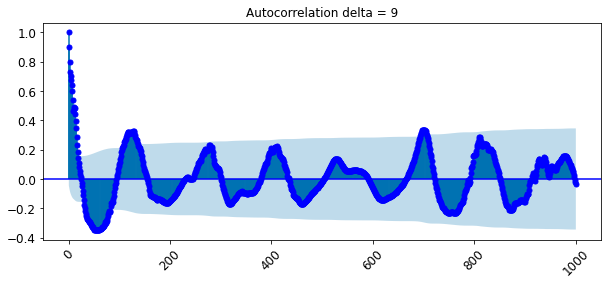

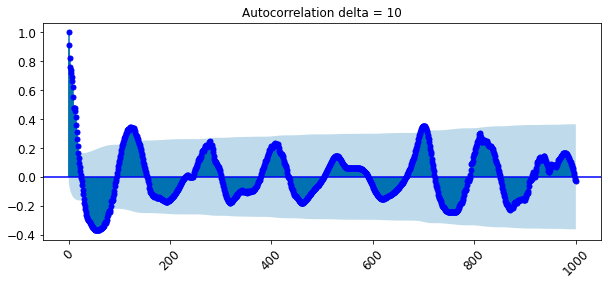

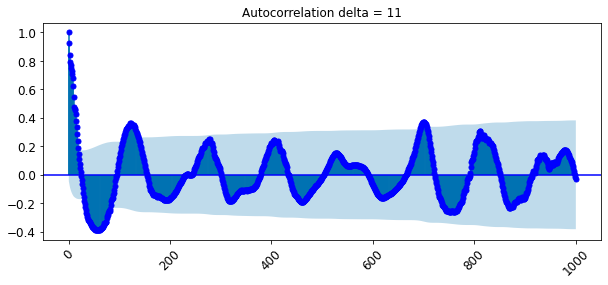

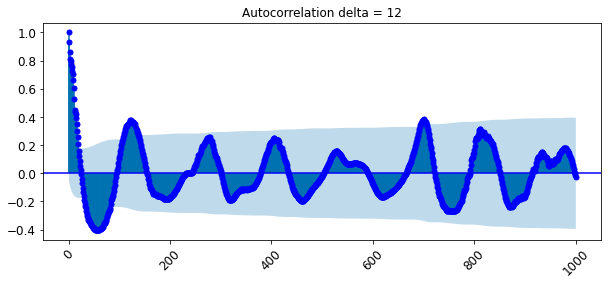

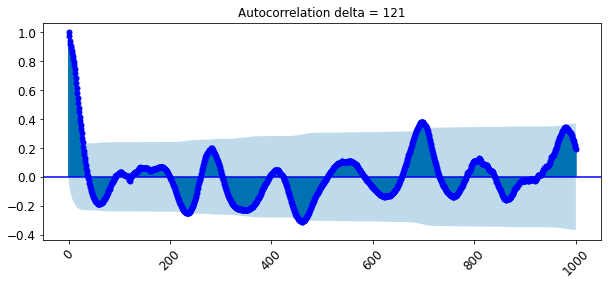

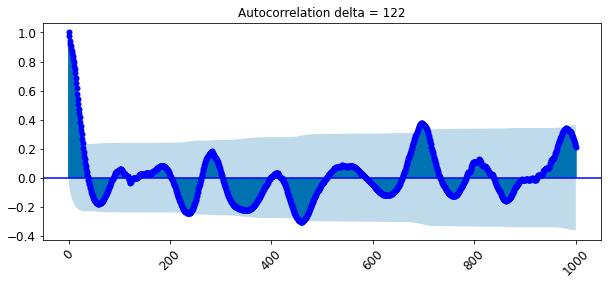

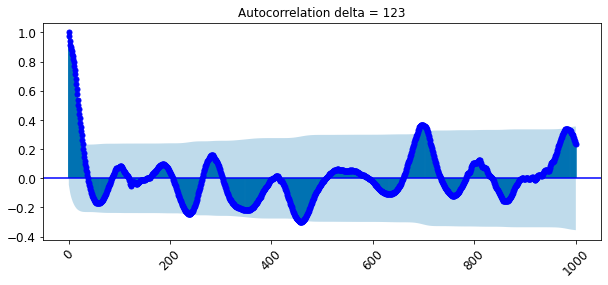

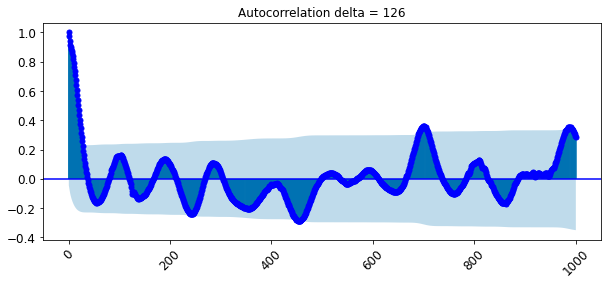

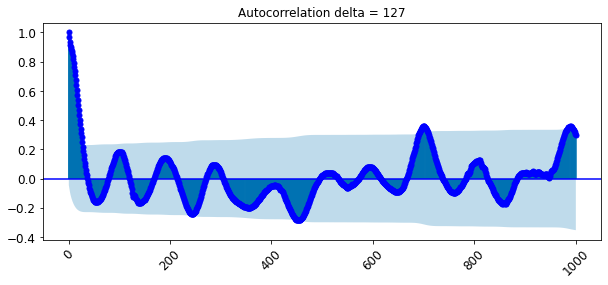

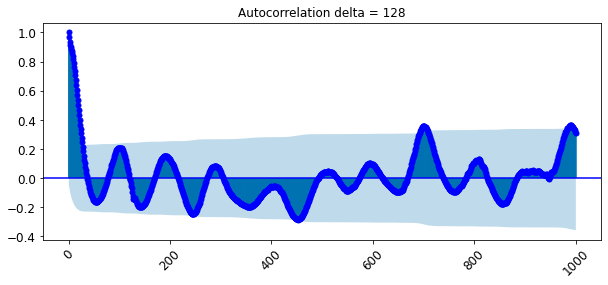

In [21]:
plt.rcParams["figure.figsize"] = (10,4)
p =1000


plot_acf(df['Delta_9'], lags = p, unbiased=True, color ='blue', title ='Autocorrelation delta = 9')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_10'], lags = p, unbiased=True,color ='blue', title ='Autocorrelation delta = 10')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_11'], lags = p, unbiased=True,color ='blue', title ='Autocorrelation delta = 11')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_12'], lags = p, unbiased=True,color ='blue', title ='Autocorrelation delta = 12')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_121'], lags = p, unbiased=True, color ='blue', title ='Autocorrelation delta = 121')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_122'], lags = p, unbiased=True,color ='blue', title ='Autocorrelation delta = 122')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_123'], lags = p, unbiased=True,color ='blue', title ='Autocorrelation delta = 123')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_126'], lags = p, unbiased=True, color ='blue', title ='Autocorrelation delta = 126')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_127'], lags = p, unbiased=True,color ='blue', title ='Autocorrelation delta = 127')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_128'], lags = p, unbiased=True,color ='blue', title ='Autocorrelation delta = 128')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()


## method 2



period =  8


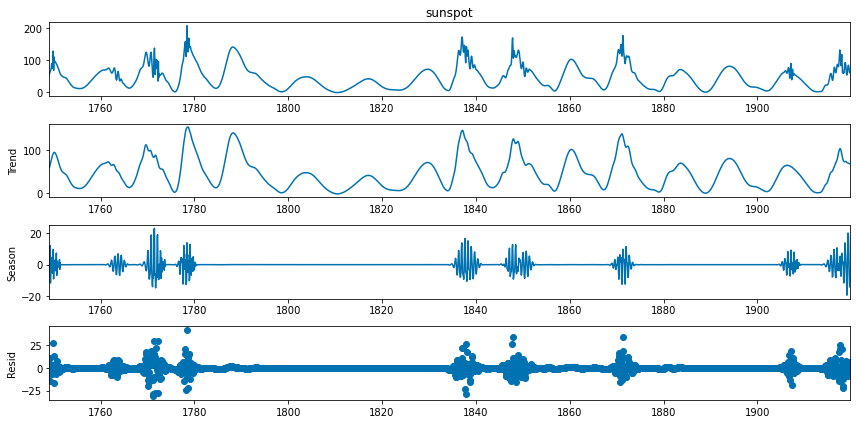



period =  9


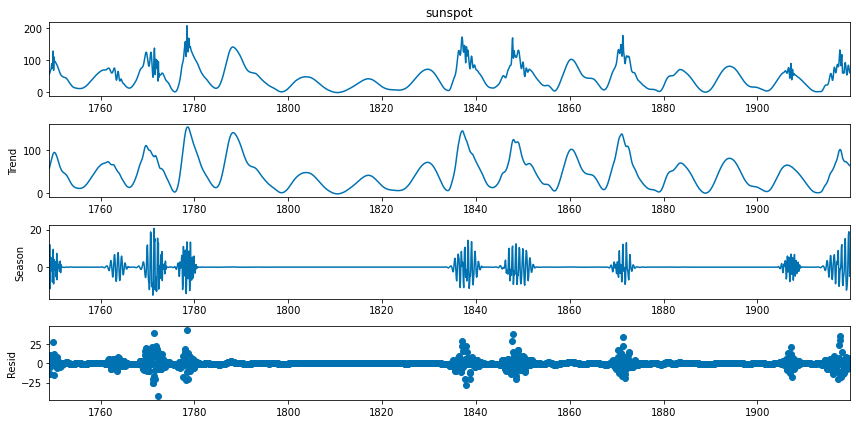



period =  10


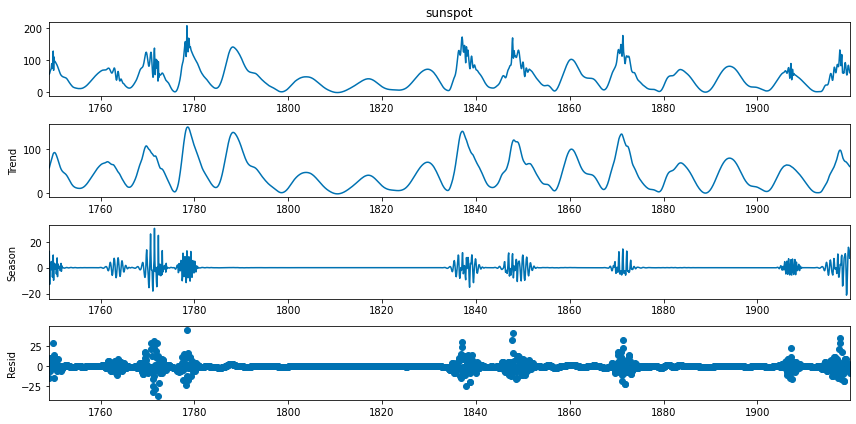



period =  11


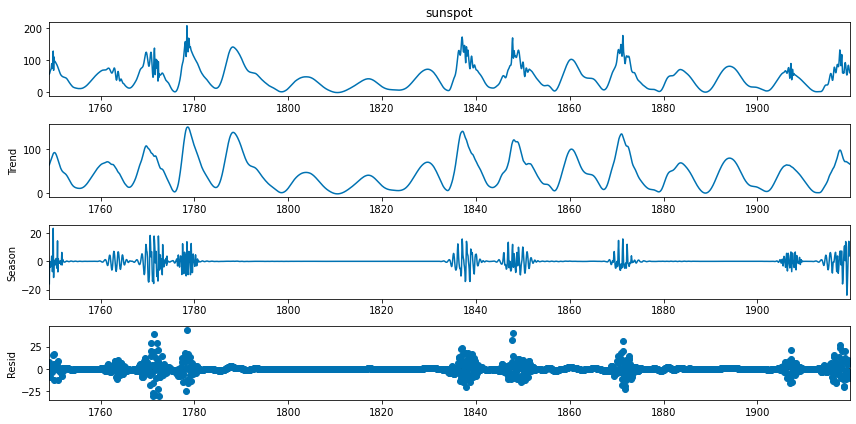



period =  12


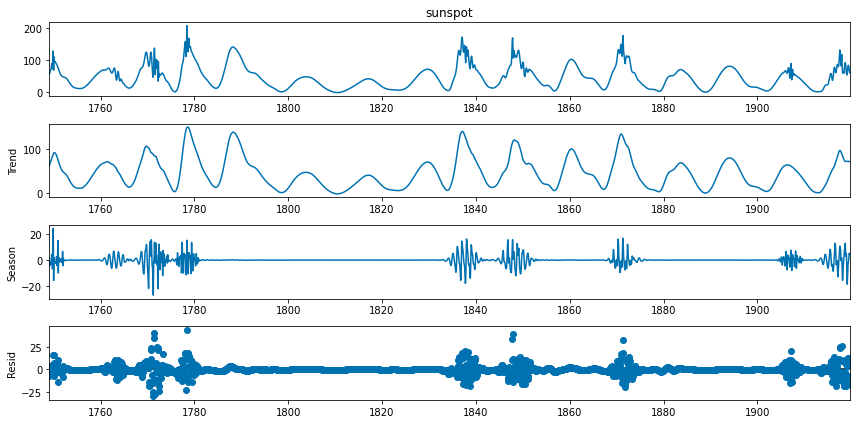

In [22]:
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (12,6)

df = pd.Series(signal_filtred, index=pd.date_range('1749', periods=len(signal_filtred), freq='M'), name = 'sunspot')
df.describe()

for i in range(8, 13):
    print("\n\nperiod = ", i)
    stl = STL(df, period =i)
    res = stl.fit()
    fig = res.plot()
    plt.show()



period =  120


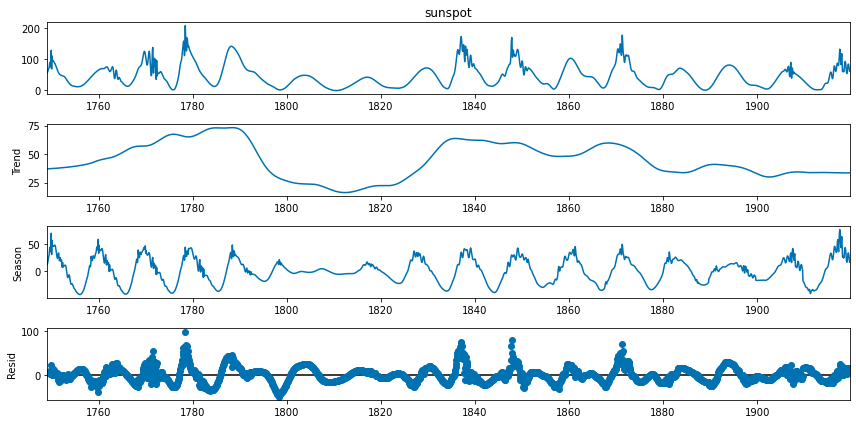



period =  121


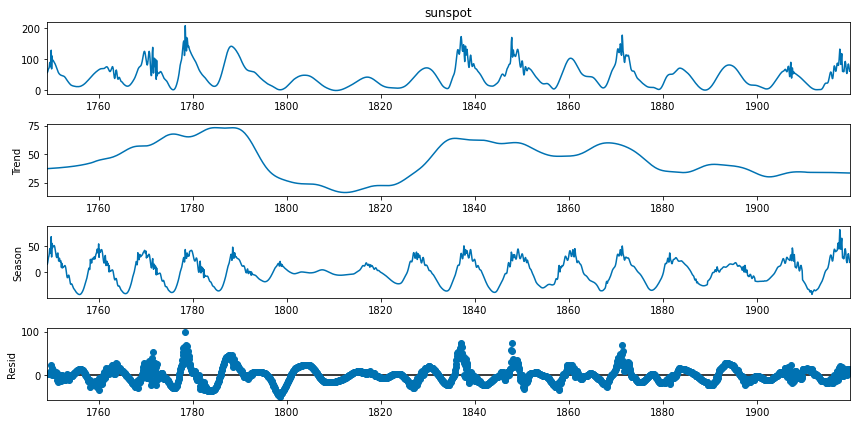



period =  122


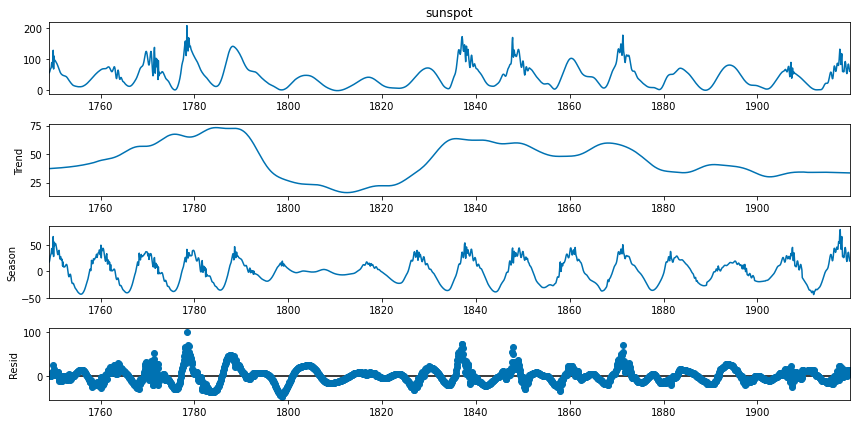



period =  123


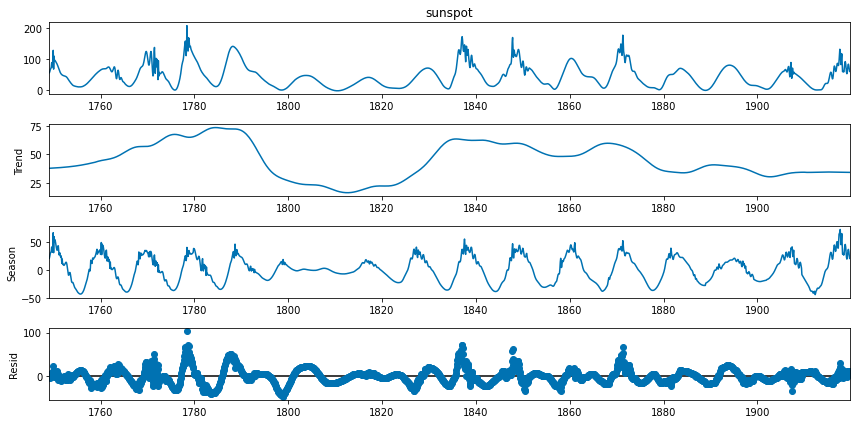



period =  124


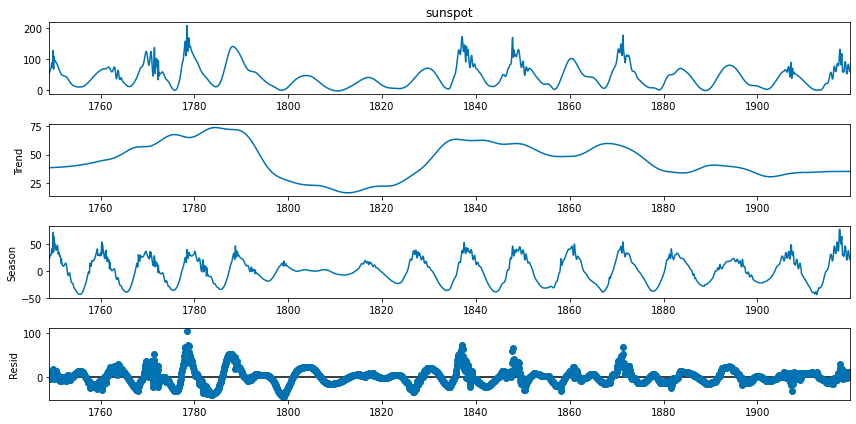



period =  125


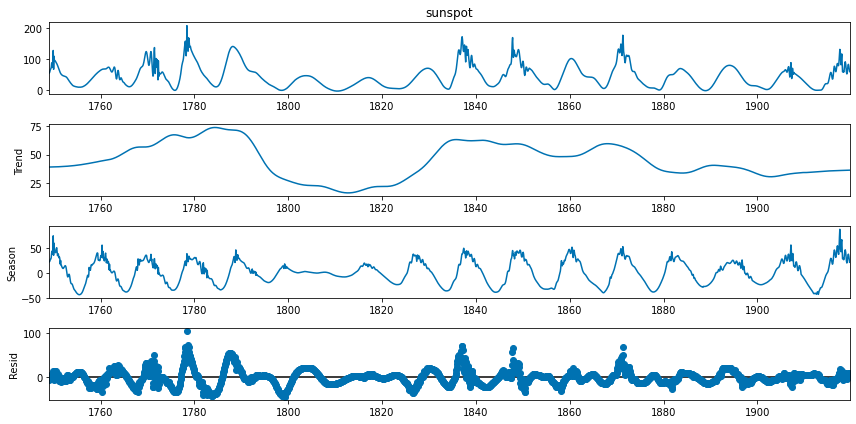



period =  126


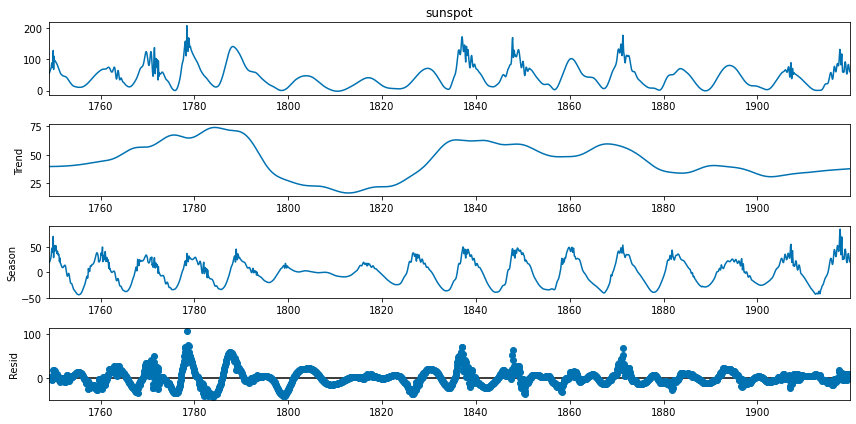



period =  127


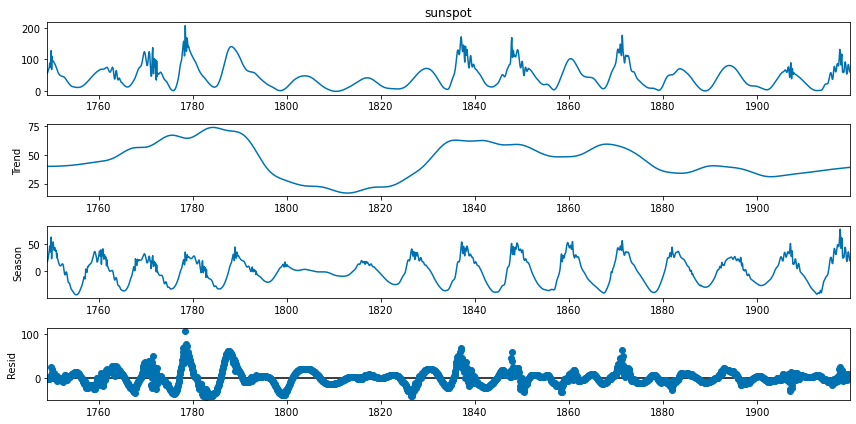



period =  128


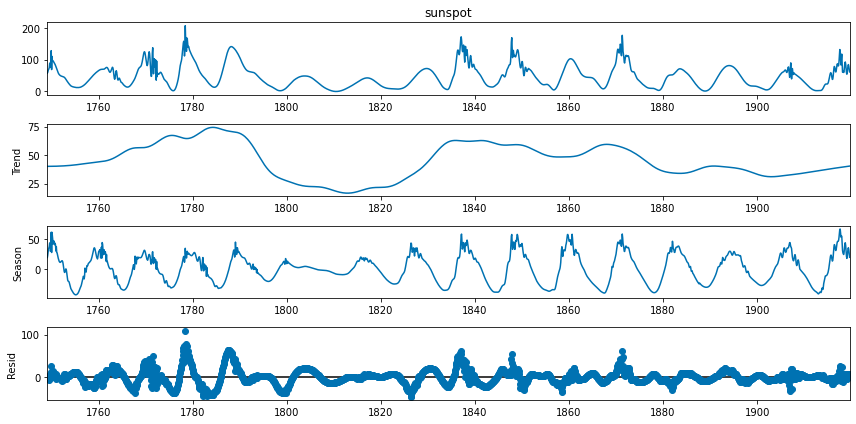



period =  129


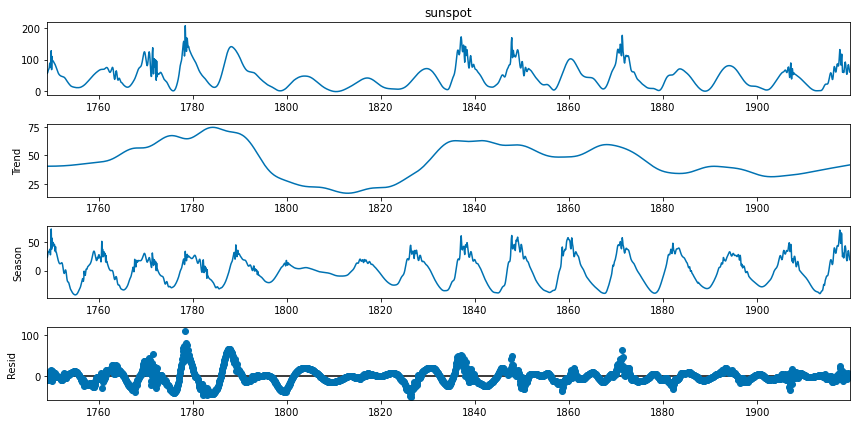

In [23]:
for i in range(120, 130):
    print("\n\nperiod = ", i)
    stl = STL(df, period =i)
    res = stl.fit()
    fig = res.plot()
    plt.show()

# De-trending data

In [24]:
df = pd.DataFrame(signal_filtred, columns = ['y_t'])

df['y_(t1)'] = df['y_t'].shift(-1)
df['y_(t2)'] = df['y_t'].shift(-2)
df['y_(t3)'] = df['y_t'].shift(-3)
df.dropna(inplace = True)

df['Delta_1'] = df['y_(t3)'] - df['y_(t2)']
df['Delta_2'] = df['y_(t3)'] - 2*df['y_(t2)']+ df['y_(t1)']
df['Delta_3'] = df['y_(t3)'] - 3*df['y_(t2)']+ 3*df['y_(t1)']- df['y_t']

df.head(6)

,y_t,y_(t1),y_(t2),y_(t3),Delta_1,Delta_2,Delta_3
0,56.381192,58.617579,63.852389,68.439816,4.587428,-0.647382,-3.645805
1,58.617579,63.852389,68.439816,69.593814,1.153998,-3.433430,-2.786047
2,63.852389,68.439816,69.593814,74.675102,5.081288,3.927290,7.360719
3,68.439816,69.593814,74.675102,87.493720,12.818618,7.737330,3.810040
4,69.593814,74.675102,87.493720,89.314913,1.821193,-10.997425,-18.734755
5,74.675102,87.493720,89.314913,74.798644,-14.516269,-16.337462,-5.340037


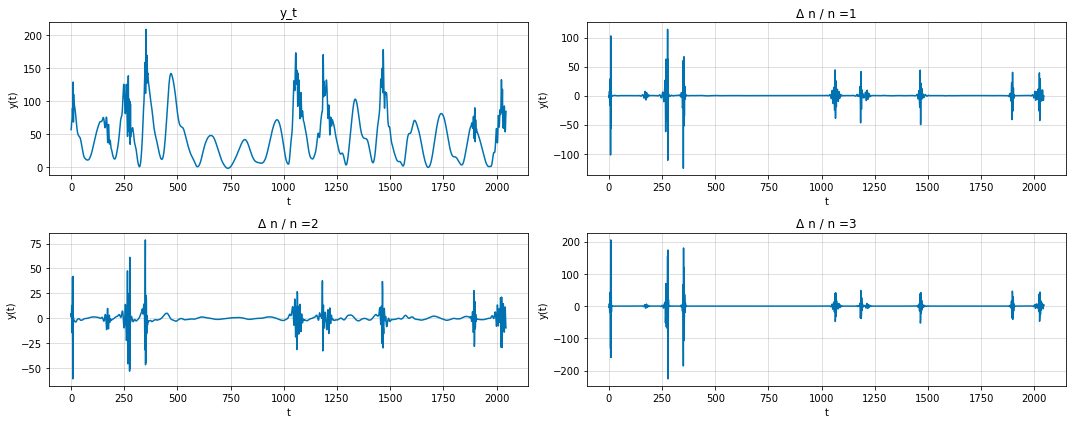

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15,6), sharex = False)

for row in axs:
    for ax in row:
        ax.grid(alpha = 0.5)
        ax.set_xlabel('t')
        ax.set_ylabel('y(t)')

axs[0][0].plot(df['y_t'])
axs[1][0].plot(df['Delta_1'])
axs[0][1].plot(df['Delta_2'])
axs[1][1].plot(df['Delta_3'])


axs[0][0].set_title('y_t')
axs[0][1].set_title(u'\u0394 n / n =1')
axs[1][0].set_title(u'\u0394 n / n =2')
axs[1][1].set_title(u'\u0394 n / n =3')

fig.tight_layout()

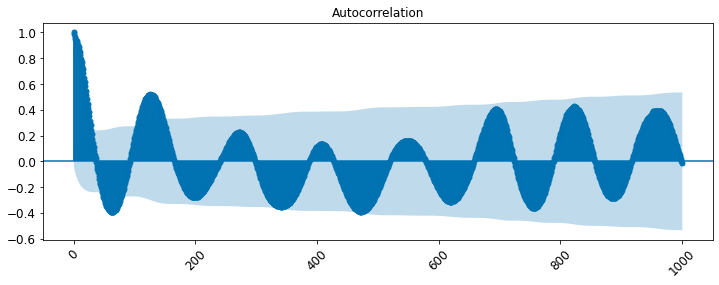

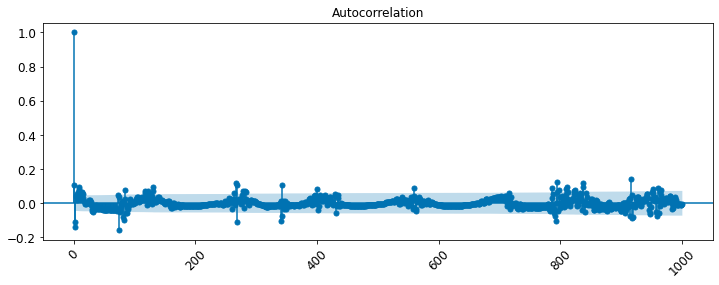

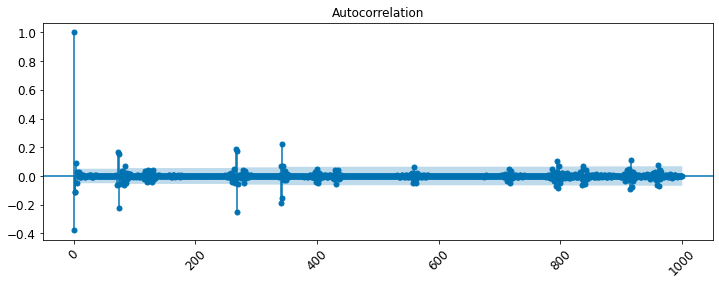

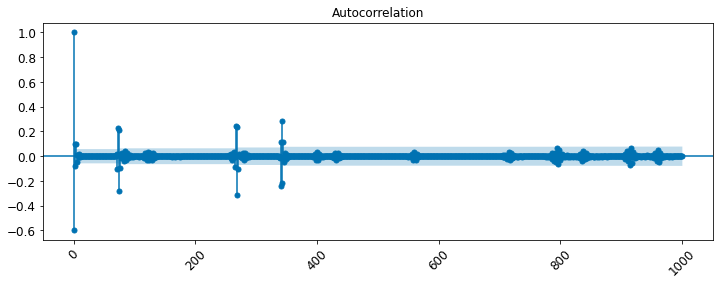

In [26]:
plt.rcParams["figure.figsize"] = (12,4)

plot_acf(df['y_t'], lags = p, unbiased=True)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_1'], lags = p, unbiased=True)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_2'], lags = p, unbiased=True)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_acf(df['Delta_3'], lags = p, unbiased=True)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

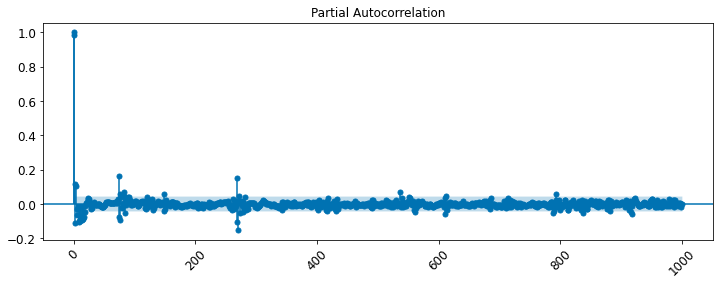

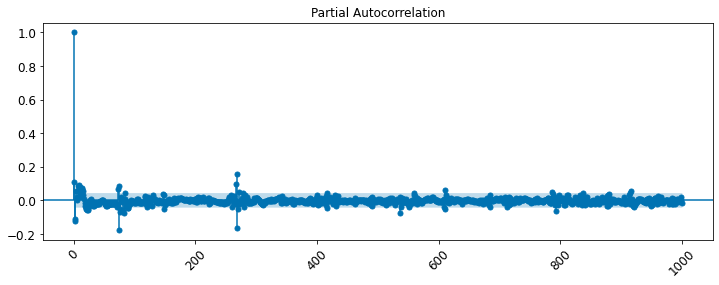

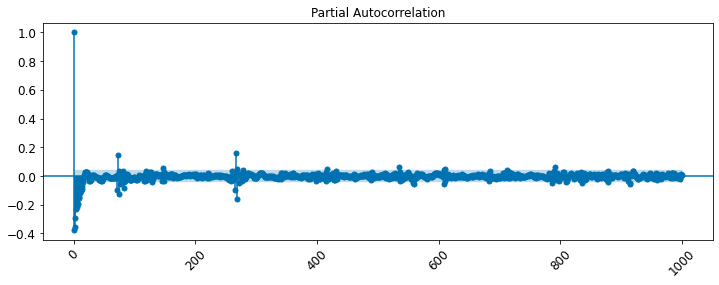

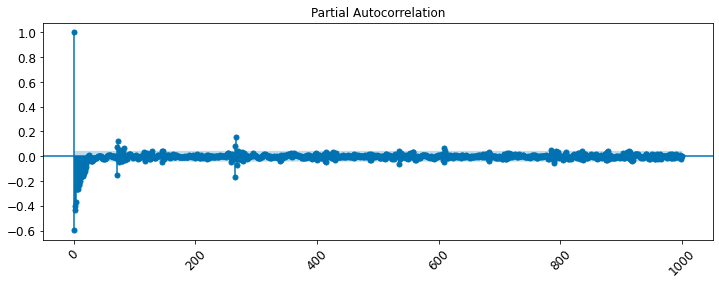

In [27]:
plot_pacf(df['y_t'], lags = p, method = 'ywmle')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_pacf(df['Delta_1'], lags = p, method = 'ywmle')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_pacf(df['Delta_2'], lags = p, method = 'ywmle')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

plot_pacf(df['Delta_3'], lags = p, method = 'ywmle')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

## Fitting ARIMA

In [28]:
def check_for_ARMA(dta, p_max, q_max):
    
    aic = pd.DataFrame(np.zeros((p_max, q_max), dtype=float))
    bic = pd.DataFrame(np.zeros((p_max, q_max), dtype=float))

    for p in range(p_max):
        for q in range(q_max):
            if p == 0 and q == 0:
                continue
            try:
                mod = sm.tsa.ARMA(dta, (p,q)).fit()
                aic.iloc[p,q] = mod.aic
                bic.iloc[p,q] = mod.bic

            except:
                aic.iloc[p,q] = np.nan
                bic.iloc[p,q] = np.nan

    return aic, bic

In [29]:
detrended_data = df['Delta_1']
aic, bic = check_for_ARMA(detrended_data, 6,6)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23664D+00    |proj g|=  1.49658D-05

At iterate    5    f=  3.23664D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   0.000D+00   3.237D+00
  F =   3.2366416003907292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22009D+00    |proj g|=  3.59712D-04

At iterate    5    f=  3.22009D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   4.441D-08   3.220D+00
  F =   3.2200912044023968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23811D+00    |proj g|=  5.84421D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      8      1     0     0   0.000D+00   3.238D+00
  F =   3.2381105789910607     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23058D+00    |proj g|=  3.35421D-04

At iterate    5    f=  3.23057D+00    |proj g|=  1.20970D-04

At iterate   10    f=  3.23057D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   0.000D+00   3.231D+00
  F =   3.2305731138629814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19938D+00    |proj g|=  9.86500D-04

At iterate    5    f=  3.19935D+00    |proj g|=  5.90505D-04


 This problem is unconstrained.



At iterate   10    f=  3.19934D+00    |proj g|=  4.44533D-05

At iterate   15    f=  3.19934D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   4.441D-08   3.199D+00
  F =   3.1993416096655398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19528D+00    |proj g|=  1.41163D-03

At iterate    5    f=  3.19525D+00    |proj g|=  5.31086D-04

At iterate   10    f=  3.19525D+00    |proj g|=  1.90958D-05

At iterate   15    f=  3.19525D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   8.882D-08   3.195D+00
  F =   3.1952455335536176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.22731D+00    |proj g|=  1.72307D-05

At iterate   10    f=  3.22731D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   0.000D+00   3.227D+00
  F =   3.2273061283937454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22443D+00    |proj g|=  6.05826D-04

At iterate    5    f=  3.22442D+00    |proj g|=  2.55618D-04

At iterate   10    f=  3.22439D+00    |proj g|=  2.97642D-03

At iterate   15    f=  3.22436D+00    |proj g|=  2.70450D-05

At iterate   20    f=  3.22436D+00    |proj g|=  1.46549D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   4.441D-08   3.224D+00
  F =   3.2243552351038036     

CONVERG

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     30      1     0     0   1.776D-07   3.222D+00
  F =   3.2216557890755113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19380D+00    |proj g|=  1.60312D-03

At iterate    5    f=  3.19365D+00    |proj g|=  2.42588D-03


 This problem is unconstrained.



At iterate   10    f=  3.19359D+00    |proj g|=  1.01030D-04

At iterate   15    f=  3.19359D+00    |proj g|=  1.21680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   1.332D-07   3.194D+00
  F =   3.1935910084857722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19369D+00    |proj g|=  1.71112D-03

At iterate    5    f=  3.19351D+00    |proj g|=  5.75096D-03

At iterate   10    f=  3.19305D+00    |proj g|=  4.13052D-03

At iterate   15    f=  3.19278D+00    |proj g|=  4.78773D-04

At iterate   20    f=  3.19277D+00    |proj g|=  4.70290D-05

At iterate   25    f=  3.19277D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     39      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22273D+00    |proj g|=  3.64597D-04

At iterate    5    f=  3.22272D+00    |proj g|=  2.56906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   4.441D-08   3.223D+00
  F =   3.2227147099089044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22218D+00    |proj g|=  5.53424D-04

At iterate    5    f=  3.22217D+00    |proj g|=  3.70814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   4.441D-08   3.222D+00
  F =   3.2221746778442895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.21097D+00    |proj g|=  1.86340D-03

At iterate   10    f=  3.21092D+00    |proj g|=  3.51763D-04

At iterate   15    f=  3.21092D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   4.441D-08   3.211D+00
  F =   3.2109220797700262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19978D+00    |proj g|=  7.79612D-03

At iterate    5    f=  3.19655D+00    |proj g|=  7.29194D-04

At iterate   10    f=  3.19653D+00    |proj g|=  4.77840D-05

At iterate   15    f=  3.19653D+00    |proj g|=  1.07470D-05

At iterate   20    f=  3.19653D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     31      1     0     0   3.109D-07   3.197D+00
  F =   3.1965344592710285     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19349D+00    |proj g|=  4.21880D-03

At iterate    5    f=  3.19236D+00    |proj g|=  1.80491D-03

At iterate   10    f=  3.19205D+00    |proj g|=  1.86051D-03

At iterate   15    f=  3.19196D+00    |proj g|=  2.09699D-04

At iterate   20    f=  3.19196D+00    |proj g|=  2.87459D-04

At iterate   25    f=  3.19196D+00    |proj g|=  3.12195D-05

At iterate   30    f=  3.19196D+00    |proj g|=  5.72875D-06

At iterate   35    f=  3.19196D+00    |proj g|=  6.66134D-07

At iterate   40    f=  3.19196D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19381D+00    |proj g|=  3.60010D-03

At iterate    5    f=  3.19358D+00    |proj g|=  5.55440D-03

At iterate   10    f=  3.19310D+00    |proj g|=  1.73048D-03

At iterate   15    f=  3.19243D+00    |proj g|=  5.70570D-03

At iterate   20    f=  3.19213D+00    |proj g|=  3.34079D-03

At iterate   25    f=  3.19208D+00    |proj g|=  1.10099D-03

At iterate   30    f=  3.19203D+00    |proj g|=  7.20890D-04

At iterate   35    f=  3.19186D+00    |proj g|=  3.12808D-03

At iterate   40    f=  3.19179D+00    |proj g|=  4.55724D-04

At iterate   45    f=  3.19178D+00    |proj g|=  1.21947D-04

At iterate   50    f=  3.19178D+00    |proj g|=  5.32907D-06

At iterate   55    f=  3.19178D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22203D+00    |proj g|=  6.34381D-04

At iterate    5    f=  3.22202D+00    |proj g|=  2.77112D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   8.882D-08   3.222D+00
  F =   3.2220234276240918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21055D+00    |proj g|=  3.82405D-04

At iterate    5    f=  3.21054D+00    |proj g|=  2.27507D-04

At iterate   10    f=  3.21054D+00    |proj g|=  2.44249D-05

At iterate   15    f=  3.21054D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     19      1     0     0   4.441D-08   3.211D+00
  F =   3.2105446027709554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20450D+00    |proj g|=  8.06839D-03

At iterate    5    f=  3.19657D+00    |proj g|=  8.30007D-03

At iterate   10    f=  3.19488D+00    |proj g|=  7.72165D-03

At iterate   15    f=  3.19456D+00    |proj g|=  8.35776D-05

At iterate   20    f=  3.19456D+00    |proj g|=  1.26121D-05

At iterate   25    f=  3.19456D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     41      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  3.19359D+00    |proj g|=  1.98170D-03

At iterate   15    f=  3.19251D+00    |proj g|=  3.58451D-03

At iterate   20    f=  3.19215D+00    |proj g|=  3.77498D-03

At iterate   25    f=  3.19186D+00    |proj g|=  8.98392D-04

At iterate   30    f=  3.19174D+00    |proj g|=  1.34066D-03

At iterate   35    f=  3.19172D+00    |proj g|=  5.05596D-04

At iterate   40    f=  3.19172D+00    |proj g|=  7.63833D-06

At iterate   45    f=  3.19172D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     60      1     0     0   3.109D-07   3.192D+00
  F =   3.19171998583

 This problem is unconstrained.



At iterate   10    f=  3.19363D+00    |proj g|=  1.89591D-03

At iterate   15    f=  3.19265D+00    |proj g|=  3.52935D-03

At iterate   20    f=  3.19206D+00    |proj g|=  2.94742D-03

At iterate   25    f=  3.19183D+00    |proj g|=  1.91140D-03

At iterate   30    f=  3.19181D+00    |proj g|=  1.16751D-04

At iterate   35    f=  3.19181D+00    |proj g|=  1.91935D-04

At iterate   40    f=  3.19181D+00    |proj g|=  3.09486D-04

At iterate   45    f=  3.19179D+00    |proj g|=  1.16596D-03

At iterate   50    f=  3.19175D+00    |proj g|=  1.11471D-03

At iterate   55    f=  3.19167D+00    |proj g|=  1.13700D-03

At iterate   60    f=  3.19158D+00    |proj g|=  3.87796D-03

At iterate   65    f=  3.19150D+00    |proj g|=  2.06031D-03

At iterate   70    f=  3.19144D+00    |proj g|=  9.04699D-04

At iterate   75    f=  3.19138D+00    |proj g|=  6.53610D-04

At iterate   80    f=  3.19138D+00    |proj g|=  3.92886D-04

At iterate   85    f=  3.19138D+00    |proj g|=  1.07914D-05

At iter

In [30]:
aic

,0,1,2,3,4,5
0,0.000000,13243.864146,13232.885529,13197.333764,13195.294313,13184.173026
1,13249.872268,13242.240982,13223.044036,13197.375702,13099.307184,13084.554232
2,13219.489357,13209.682065,13199.612912,13190.572177,13077.787225,13076.413162
3,13195.330638,13192.903164,13191.411642,NaN,NaN,NaN
4,13190.694432,13146.671306,13089.825938,NaN,13075.101258,13076.370064
5,13192.075819,13147.127425,13083.762939,NaN,13076.134742,13076.741897


In [31]:
bic

,0,1,2,3,4,5
0,0.000000,13260.733605,13255.378141,13225.449529,13229.033232,13223.535097
1,13266.741727,13264.733595,13251.159801,13231.114620,13138.669255,13129.539457
2,13241.981970,13237.797830,13233.351830,13229.934249,13122.772449,13127.021539
3,13223.446403,13226.642082,13230.773714,NaN,NaN,NaN
4,13224.433351,13186.033378,13134.811163,NaN,13131.332789,13138.224747
5,13231.437890,13192.112650,13134.371316,NaN,13137.989426,13144.219734


In [32]:
p = 4
q = 4

model = sm.tsa.ARMA(detrended_data, (p,q)).fit()
print("aic = {:}\t bic = {:}".format(model.aic, model.bic))
print("\n\n parameters: {:}".format(model.params))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19349D+00    |proj g|=  4.21880D-03

At iterate    5    f=  3.19236D+00    |proj g|=  1.80491D-03

At iterate   10    f=  3.19205D+00    |proj g|=  1.86051D-03

At iterate   15    f=  3.19196D+00    |proj g|=  2.09699D-04

At iterate   20    f=  3.19196D+00    |proj g|=  2.87459D-04

At iterate   25    f=  3.19196D+00    |proj g|=  3.12195D-05

At iterate   30    f=  3.19196D+00    |proj g|=  5.72875D-06

At iterate   35    f=  3.19196D+00    |proj g|=  6.66134D-07

At iterate   40    f=  3.19196D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

# Conclusion:

sunspot data can be modelled as ARIMA(4,4) or similar.
All attempts to fit seasonality to sunspot data failed